# Pytorch HeteroData for KG and Feasibility Graph Generation
In this notebook we will see how to create a Knowledge or feasibility graph for enforcing certain business rules in the training process.

[Pytorch Link](https://pytorch-geometric.readthedocs.io/en/2.5.0/generated/torch_geometric.data.HeteroData.html)

Prerequisites:
* pip install torch torch-geometric pandas networkx tqdm matplotlib

### Step 1: Install the required libraries

You can install the required libraries via pip if you haven't already:

`!pip install torch torch-geometric pandas networkx tqdm matplotlib`

### Step 2: Import necessary libraries

In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.data import HeteroData
import pandas as pd
import numpy as np
from tqdm import tqdm

# Demo 1

In [7]:
data = HeteroData()

num_papers = 1000
num_authors = 300
num_paper_features = 16
num_authors_features = 8
# Create two node types "paper" and "author" holding a feature matrix:
data['paper'].x = torch.randn(num_papers, num_paper_features)
data['author'].x = torch.randn(num_authors, num_authors_features)

# Create an edge type "(author, writes, paper)" and building the
# graph connectivity:
data['author', 'writes', 'paper'].edge_index = torch.randint(0, num_papers, (2, 5000))

In [8]:
print('Number of paper nodes:')
print(data['paper'].num_nodes)

print('Number of edges for the relation (author, writes, paper):')
print(data['author', 'writes', 'paper'].num_edges)

Number of paper nodes:
1000
Number of edges for the relation (author, writes, paper):
5000


# Demo 2

In [114]:
data = torch.load('graph.pt', weights_only=False)

In [82]:
data['person'].x

tensor([[ 21.,  20.],
        [ 31., 500.]])

In [113]:
data['person', 'affiliated', 'institution'].edge_index

tensor([[0],
        [0]])

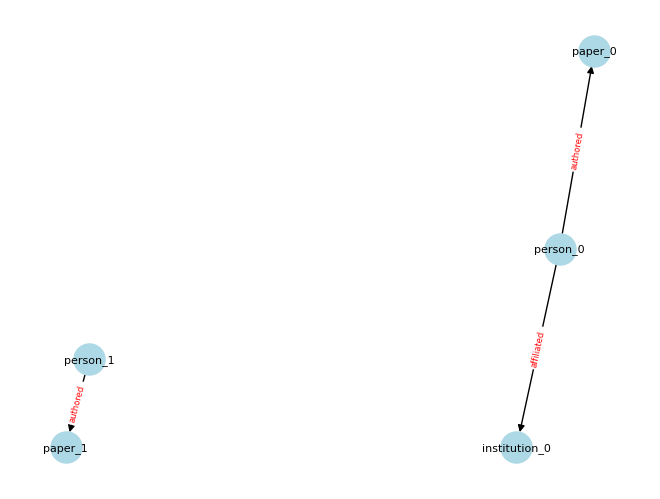

In [83]:
# Visualize the HeteroData object using networkx
import networkx as nx
import matplotlib.pyplot as plt

def visualize_heterodata(hetero_data):
    G = nx.MultiDiGraph()
    for node_type in hetero_data.node_types:
        num_nodes = hetero_data[node_type].num_nodes
        for i in range(num_nodes):
            G.add_node(f"{node_type}_{i}", label=node_type)
    for edge_type in hetero_data.edge_types:
        src_type, rel_type, dst_type = edge_type
        edge_index = hetero_data[edge_type].edge_index
        for src, dst in edge_index.t().tolist():
            G.add_edge(f"{src_type}_{src}", f"{dst_type}_{dst}", label=rel_type)
    pos = nx.spring_layout(G)
    edge_labels = nx.get_edge_attributes(G, 'label')
    node_labels = nx.get_node_attributes(G, 'label')
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=8)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=6)
    plt.show()
visualize_heterodata(data)

In [84]:
# Count the number of node features for each node type
node_feature_counts = {}
edge_feature_counts = {}
for node_type in data.node_types:
    num_features = data[node_type].x.size(1)
    node_feature_counts[node_type] = num_features
for edge_type in data.edge_types:
    num_features = data[edge_type].edge_attr.size(1) if 'edge_attr' in data[edge_type] else 0
    edge_feature_counts[edge_type] = num_features
print("Node feature counts:", node_feature_counts)
print("Edge feature counts:", edge_feature_counts)

Node feature counts: {'person': 2, 'paper': 1, 'institution': 1}
Edge feature counts: {('person', 'authored', 'paper'): 1, ('person', 'affiliated', 'institution'): 1}


In [ ]:
# Use nn.ModuleList, nn.Embedding, HeteroConv, TransformerConv to build a GNN model for the HeteroData object
# -----IMPORTANT----- Don't forget to scale the node and edge features, if necessary, before feeding them to the model (This Demo doesn't include scaling for simplicity)
from torch import nn
from torch_geometric.nn import HeteroConv, TransformerConv
class HeteroGNN(nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, node_feature_counts, edge_feature_counts):
        super(HeteroGNN, self).__init__()
        self.node_encoders = nn.ModuleDict({
            node_type: nn.Linear(in_features=node_feature_counts[node_type], out_features=hidden_channels)
            for i, node_type in enumerate(metadata[0])
        })
        edges_type_dict = {edge_type: ''.join(edge_type) for edge_type in metadata[1]}
        self.edge_encoders = nn.ModuleDict({
            edges_type_dict[edge_type]: nn.Linear(in_features=edge_feature_counts[edge_type], out_features=hidden_channels)
            for i, edge_type in enumerate(metadata[1])
        })
        self.convs = nn.ModuleList()
        for _ in range(2):  # Two layers
            conv = HeteroConv({
                edge_type: TransformerConv(hidden_channels, hidden_channels, edge_dim=hidden_channels)
                for edge_type in metadata[1]
            }, aggr='mean')
            self.convs.append(conv)
        self.lin = nn.Linear(hidden_channels, out_channels)
    def forward(self, data):
        x_dict, edge_index_dict = data.x_dict, data.edge_index_dict
        # Encode node features
        for node_type, x in x_dict.items():
            x_dict[node_type] = self.node_encoders[node_type](x)

        # Encode edge features 
        edge_attr_dict = {}
        for edge_type, edge_index in edge_index_dict.items():
            edge_type_str = ''.join(edge_type)
            if edge_type_str in self.edge_encoders:
                edge_attr_dict[edge_type] = self.edge_encoders[edge_type_str](data[edge_type].edge_attr)

        # Apply convolutional layers
        for conv in self.convs:
            x_dict_new = conv(x_dict, edge_index_dict, edge_attr_dict)
            for node_type in x_dict:
                if node_type in x_dict_new:
                    x_dict[node_type] = x_dict_new[node_type]
            # Apply ReLU activation
            x_dict = {k: v.relu() for k, v in x_dict.items()}
        # Final linear layer
        for node_type in x_dict:
            x_dict[node_type] = self.lin(x_dict[node_type])

        hg = torch.mean(torch.stack([x.mean(dim=0) for x in x_dict.values()]), dim=0)
        return x_dict, hg
model = HeteroGNN(data.metadata(), hidden_channels=32, out_channels=16, node_feature_counts=node_feature_counts, edge_feature_counts=edge_feature_counts)
x_dict, hg = model(data)
print(hg)

tensor([ 24.7164, -25.6660,  10.1077, -39.4577,  35.4717,   3.4412,  37.0469,
         26.7077, -29.7325,  -5.9645, -20.6709,  19.2377,  15.1344,  -2.6616,
        -27.5316,  -9.4280], grad_fn=<MeanBackward1>)


/var/folders/qm/f1v1yrq96d5gphcg52t9_5380000gn/T/ipykernel_58115/765233928.py:19: UserWarning: There exist node types ({'person'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behavior.
  conv = HeteroConv({


In [123]:
# Decode the node embedding to get scores for a specific task
class NodeDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(NodeDecoder, self).__init__()
        self.lin1 = nn.Linear(in_channels, in_channels // 2)
        self.lin2 = nn.Linear(in_channels // 2, out_channels)
    def forward(self, x):
        x = self.lin1(x).relu()
        x = self.lin2(x)
        return x
# Example usage:
decoder = NodeDecoder(in_channels=16, out_channels=1)  # Assuming binary classification
# Decode embeddings for a random node type
node_type = data.node_types[0]
node_embeddings = x_dict[node_type]
scores = decoder(node_embeddings)
print(f'scores for node type {node_type}:')
print(scores)

scores for node type person:
tensor([[0.5040],
        [1.5700]], grad_fn=<AddmmBackward0>)


## To know more about action masking read:
A Closer Look at Invalid Action Masking in Policy Gradient Algorithms ([Link](https://arxiv.org/abs/2006.14171))

In [129]:
# Filter nodes of a specific type based on a condition on their features
def filter_nodes_by_feature(data, node_type, feature_index, threshold):
    x = data[node_type].x
    mask = x[:, feature_index] > threshold
    filtered_indices = mask.nonzero(as_tuple=True)[0]
    return filtered_indices
# Example usage:
filtered_node_indices = filter_nodes_by_feature(data, 'person', feature_index=0, threshold=25)
print('Filtered node indices for "paper" with feature 0 > threshold:')
print(filtered_node_indices)

Filtered node indices for "paper" with feature 0 > threshold:
tensor([1])


In [138]:
# use masking to find the feasible nodes
def feasibility_mask(scores, feasible_indices):
    mask = torch.zeros_like(scores, dtype=torch.bool)
    mask[feasible_indices] = True
    return mask
# Example usage:
feasible_indices = filtered_node_indices  # Using previously filtered indices as feasible
mask = feasibility_mask(scores.squeeze(), feasible_indices)
masked_scores = scores.masked_fill(mask.unsqueeze(1), -1e9)  # Mask infeasible nodes with a large negative value
print('Masked scores for feasible nodes:')
print(masked_scores)

Masked scores for feasible nodes:
tensor([[ 5.0404e-01],
        [-1.0000e+09]], grad_fn=<MaskedFillBackward0>)


In [140]:
# get softmax of the scores
softmax_scores = torch.softmax(masked_scores, dim=0)
print('Softmax scores:')
print(softmax_scores)

Softmax scores:
tensor([[1.],
        [0.]], grad_fn=<SoftmaxBackward0>)


# Demo 3

A real business case: Imagine 